In [35]:
import os
from collections import namedtuple


import pandas as pd
import numpy as np
import duckdb


Benchmark = namedtuple("Benchmark", ["id", "description", "ts", "freq_GHz"])

def get_db_conn():
    results_dir = os.path.abspath('')
    results_db = os.path.join(results_dir, "results.db")
    conn = duckdb.connect(results_db)
    return conn



conn = get_db_conn()


In [41]:
def get_approx_size_MB(N):
    size_matrix_bytes = N * N * 8
    all = size_matrix_bytes * 3
    return all / (2 ** 20)

N = 1200
size = get_approx_size_MB(N)
print(f"N={N}, size: {size}")

# N=50:  58KB
# N=1200: 32 MB

N=50, size: 58.59375


In [30]:

# latest benchmark result
bench_sql = """
select * from (
    select
        id,
        last_value(description ignore nulls) over (
            order by id asc
            rows between unbounded preceding and current row
        ) as desc,
        ts_added,
        cycles_frequency_GHz
    from benchmark
)where id = (select max(id) from benchmark)
"""
bench = Benchmark(*conn.sql(bench_sql).fetchone())

results_sql = """
select * exclude bench_id 
from results where bench_id = ?
order by N asc
"""
results_df = conn.execute(results_sql, [bench.id]).df()
results_df

,N,jki,kji,jik,ijk,kij,ikj
0,50,1.798320e+05,1.747240e+05,214480.0,213456.0,129996.0,168908.0
1,100,1.472652e+06,1.336026e+06,1885474.0,1849160.0,1018456.0,1050288.0
2,150,5.342424e+06,5.207424e+06,6654680.0,6723610.0,3383274.0,3371074.0
3,200,1.324799e+07,1.343068e+07,16662736.0,16802770.0,8372882.0,8042510.0
4,250,2.640560e+07,2.618820e+07,33237816.0,33789866.0,16554296.0,15726406.0
5,300,5.806398e+07,5.873454e+07,58328210.0,58754580.0,28159000.0,27051520.0
6,350,1.057899e+08,1.074203e+08,92337288.0,91491408.0,43148104.0,42973104.0
7,400,2.005629e+08,2.093996e+08,143598736.0,144534278.0,71087328.0,63474786.0
8,450,2.302322e+08,2.322294e+08,202052268.0,203550230.0,93759046.0,90677276.0
9,500,3.221340e+08,3.257241e+08,285626016.0,282906926.0,128386440.0,124022234.0


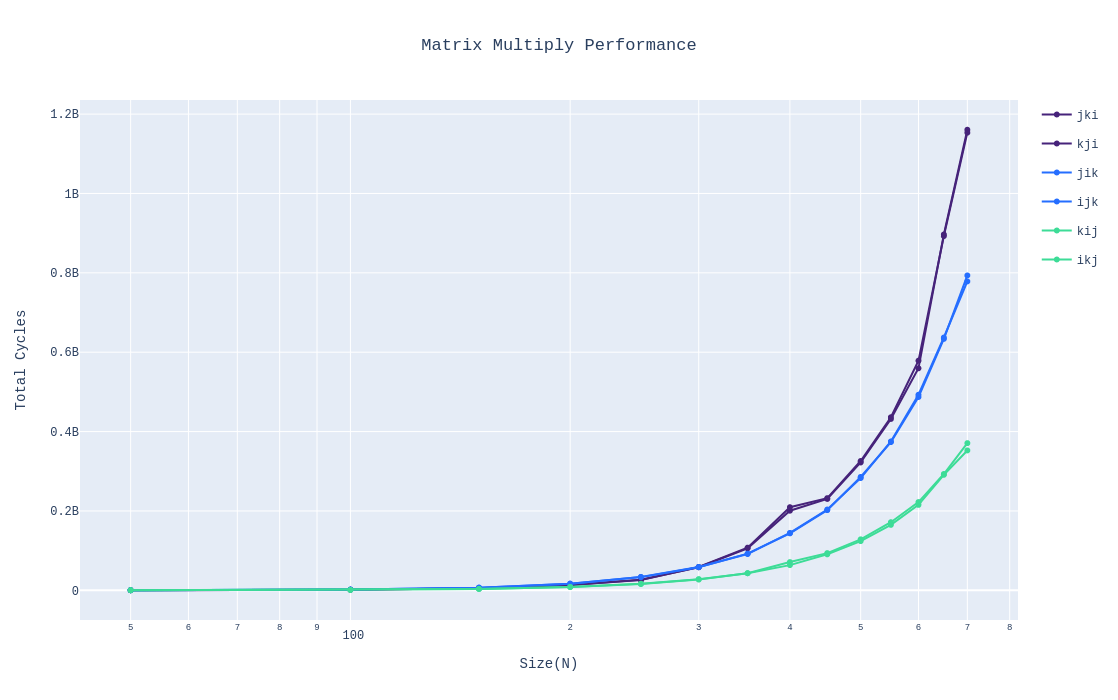

In [102]:
import plotly.express as px
import plotly.graph_objects as go

# column groupings
cols = {
    # inner loop: column-wise access of A & C
    "AC": { "names": ["jki", "kji"], "color": "#46237a"}, 
    
    # inner loop: row-wise access of A, column-wise access of B
    "AB": { "names": ["jik", "ijk"], "color": "#256eff"}, 

    # inner loop: row-wise access of B & C
    "BC": { "names": ["kij", "ikj"], "color": "#3ddc97"}, 
}


def fig_args(cols, class_):
    ys = cols[class_]["names"]
    color = cols[class_]["color"]
    colors = {y:color for y in ys}
    return {
        "x": "N",
        "y": ys,
        "markers": True,
        "color_discrete_map":colors,
    }

figAC = px.line(results_df, **fig_args(cols, "AC"))
figAB = px.line(results_df, **fig_args(cols, "AB"))
figBC = px.line(results_df, **fig_args(cols, "BC"))

layout = {
    "font": {"family": "Courier New"},
    "title_text": "Matrix Multiply Performance",
    "title_x": 0.5,
    "xaxis_title":"Size(N)",
    "yaxis_title":"Total Cycles",
    "height": 700,
}

fig = go.Figure(layout=layout,data=figAC.data + figAB.data + figBC.data)
# fig.update_yaxes(type="log")
fig.show()